## Analisi dei dati

In [ ]:
import torch.nn as nn
import torch
import os
import shutil
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive

# Il dataset è presente su Google Drive come file zip
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Estrazione del contenuto del dataset
!unzip "/content/drive/MyDrive/Alzheimer_s_Dataset.zip" -d "/content/Alzheimer_s_Dataset"

In [ ]:
# Percorso del dataset decompresso
data = 'Alzheimer_s_Dataset'
data_dir_train = 'Alzheimer_s_Dataset/train'
data_dir_test = 'Alzheimer_s_Dataset/test'

In [ ]:
import os
import shutil

def merge_categories(parent_dir):
    # Unisci le categorie in 'Demented'
    for category in ['MildDemented', 'ModerateDemented', 'VeryMildDemented']:
        src_dir = os.path.join(parent_dir, category)
        dest_dir = os.path.join(parent_dir, 'Demented')
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)
        for file_name in os.listdir(src_dir):
            src_file_path = os.path.join(src_dir, file_name)
            new_file_name = f"{category}_{file_name}"
            dest_file_path = os.path.join(dest_dir, new_file_name)
            shutil.move(src_file_path, dest_file_path)

def remove_empty_folders(parent_dir):
    # Rimuovi le cartelle vuote
    for category in ['MildDemented', 'ModerateDemented', 'VeryMildDemented']:
        dir_path = os.path.join(parent_dir, category)
        if os.path.exists(dir_path) and len(os.listdir(dir_path)) == 0:
            os.rmdir(dir_path)

# Esegui le operazioni sulle cartelle di training e test
for directory in [data_dir_train, data_dir_test]:
    merge_categories(directory)
    remove_empty_folders(directory)

## Data Augmentation

In [ ]:
import random
import cv2

# Funzione di augmentation che esegue flip casuali e rotazioni
def augment_image(input_image_path, output_image_path):
    image = cv2.imread(input_image_path)

    # Flip casuale
    flip_hor = random.choice([True, False])
    if flip_hor:
        image = cv2.flip(image, 1)  # Flip orizzontale

    # Rotazione casuale
    angle = random.randint(-10, 10)
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows))

    # Salva l'immagine augmentata
    cv2.imwrite(output_image_path, image)

# Funzione per bilanciare le classi nel dataset di training
def balance_classes(data_type_dir, class_name, target_count=3000):
    class_dir = os.path.join(data_type_dir, class_name)
    current_count = len(os.listdir(class_dir))
    augmentations_needed = target_count - current_count

    if augmentations_needed > 0:
        for i in range(augmentations_needed):
            random_image_name = random.choice(os.listdir(class_dir))
            random_image_path = os.path.join(class_dir, random_image_name)
            augmented_image_name = f"aug_{i}_{random_image_name}"
            augmented_image_path = os.path.join(class_dir, augmented_image_name)
            augment_image(random_image_path, augmented_image_path)
    else:
        print(f"La classe {class_name} ha già {current_count} immagini, non sono necessarie ulteriori augmentations.")

In [ ]:
# Bilancia la classe 'Demented' nel dataset di training
balance_classes(data_dir_train, 'Demented')

# Bilancia la classe 'NonDemented' nel dataset di training (assumendo che esista già questa cartella)
balance_classes(data_dir_train, 'NonDemented')

## Pulizia della cache

In [ ]:
# Percorso della cartella .ipynb_checkpoints
checkpoints_path = os.path.join(data_dir_train, '.ipynb_checkpoints')

# Controlla se la cartella .ipynb_checkpoints esiste e, in tal caso, la elimina
if os.path.exists(checkpoints_path):
    shutil.rmtree(checkpoints_path)
    print(f"Cartella {checkpoints_path} rimossa.")

## Trasformazioni

In [ ]:
# Trasformazioni standard per il set di addestramento
standard_transforms = transforms.Compose([
    transforms.Resize((227, 227)),  # Ridimensionamento per AlexNet
    transforms.Grayscale(num_output_channels=1),  # Conversione in scala di grigi
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalizzazione per un singolo canale
])

## Modifiche apportate al modello

In [ ]:
from torchvision.models import alexnet, AlexNet_Weights

# Carica AlexNet pre-addestrata
weights = AlexNet_Weights.DEFAULT
alexnet = alexnet(weights=weights)

# Modifica del primo strato convoluzionale
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)

# Utilizzo di euristica per l'inizializzazione dei pesi
nn.init.kaiming_normal_(alexnet.features[0].weight, mode='fan_in', nonlinearity='relu')
if alexnet.features[0].bias is not None:
    nn.init.constant_(alexnet.features[0].bias, 0)

# Modifica dell'ultimo strato fully-connected per la classificazione binaria
alexnet.classifier[6] = nn.Linear(4096, 1)

# Aggiunta della funzione di attivazione sigmoide all'ultimo strato
alexnet.classifier.add_module("7", nn.Sigmoid())

# Congelamento dei pesi dei primi strati
for param in alexnet.features.parameters():
    param.requires_grad = False

# Configurazione CUDA
if torch.cuda.is_available():
    print("CUDA è disponibile. I modelli possono essere eseguiti sulla GPU.")
else:
    print("CUDA non è disponibile.")

# Impostazione del dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 50.3MB/s]


CUDA non è disponibile.


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Caricamento immagini e definizione di funzioni di test e train

In [ ]:
train_dataset = datasets.ImageFolder(data_dir_train, transform=standard_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(train_dataset)
print(train_loader.batch_size)

Dataset ImageFolder
    Number of datapoints: 6000
    Root location: Alzheimer_s_Dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.485], std=[0.229])
           )
32


Numero totale di immagini nel dataset: 6000
Classi nel dataset: ['Demented', 'NonDemented']


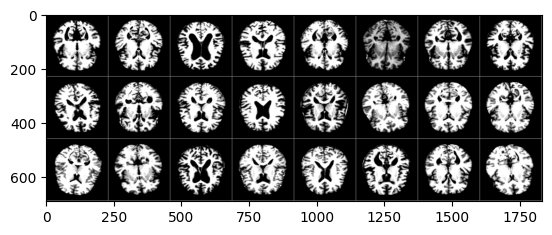

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Funzione per mostrare un'immagine
def imshow(img):
    img = img / 2 + 0.5  # Normalizza i valori per riportarli nel range [0, 1]
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)  # Assicurati che i valori siano nel range [0, 1]
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Stampa alcune informazioni di base sul dataset
print(f"Numero totale di immagini nel dataset: {len(train_dataset)}")
print(f"Classi nel dataset: {train_dataset.classes}")

# Ottieni alcune immagini di esempio dal DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostra le immagini
imshow(torchvision.utils.make_grid(images[:24]))

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

num_epochs = 30

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Imposta il modello in modalità addestramento

        train_loss = 0.0
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Controlla e regola le dimensioni dell'output
            if outputs.dim() > 1 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)

            # Controlla e regola le dimensioni delle labels
            if labels.dim() > 1:
                labels = labels.squeeze()

            # Converte in float
            labels = labels.float()

            # Calcola la loss
            loss = criterion(outputs, labels)
            train_loss += loss.item() * inputs.size(0)

            loss.backward()
            optimizer.step()

            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())

        train_loss /= len(train_loader.dataset)

        train_accuracy = accuracy_score(train_labels, [p > 0.5 for p in train_preds])
        train_precision = precision_score(train_labels, [p > 0.5 for p in train_preds])
        train_recall = recall_score(train_labels, [p > 0.5 for p in train_preds])

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Loss: {train_loss:.4f} Accuracy: {train_accuracy:.4f} Precision: {train_precision:.4f} Recall: {train_recall:.4f}")

    return model

In [ ]:
test_dataset = datasets.ImageFolder(data_dir_test, transform=standard_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(test_dataset)
print(test_loader.batch_size)

Dataset ImageFolder
    Number of datapoints: 1279
    Root location: Alzheimer_s_Dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.485], std=[0.229])
           )
32


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import torch

def test_model(model, test_loader, criterion, device):
    model.eval()  # Imposta il modello in modalità di valutazione

    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Controlla e regola le dimensioni dell'output
            if outputs.dim() > 1 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)

            # Converte in float
            labels = labels.float()

            # Calcola la loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Converti gli output in predizioni binarie
            predicted = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_precision = precision_score(all_labels, all_predictions)
    test_recall = recall_score(all_labels, all_predictions)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

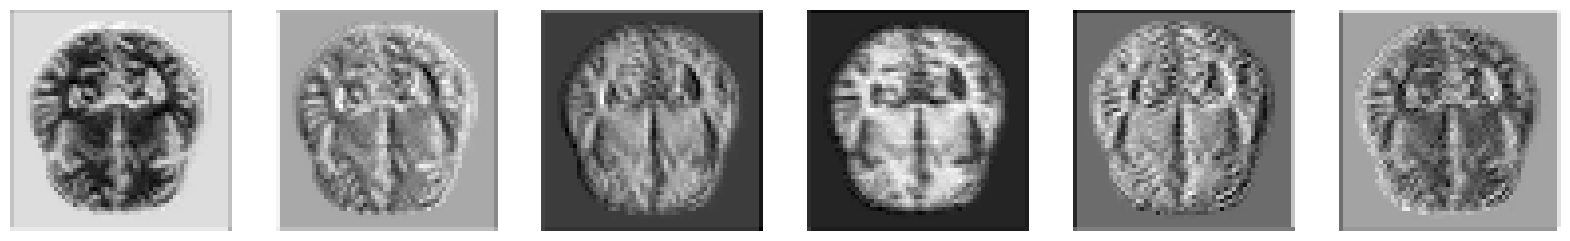

In [ ]:
from PIL import Image

# Funzione che mostra la feature map di un'immagine
def visualize_feature_maps(model, image_path, device, N=6):
    model.eval()  # Imposta il modello in modalità di valutazione
    image = Image.open(image_path).convert("L")  # Converti in scala di grigi
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        feature_maps = model.features[:1](image)

    fig, axs = plt.subplots(1, N, figsize=(20, 3))
    for i in range(N):
        axs[i].imshow(feature_maps[0, i].cpu().detach().numpy(), cmap='gray')
        axs[i].axis('off')
    plt.show()

# Chiamata della funzione
visualize_feature_maps(alexnet, 'Alzheimer_s_Dataset/train/Demented/MildDemented_mildDem2.jpg', device)

## Funzione per effettuare il salvataggio dei modelli

In [ ]:
def save_model(model_state_dict, file_name,):
    # Definizione del dizionario da salvare
    model_info = {
        'architettura': 'AlexNet Modificato',
        'model_state_dict': model_state_dict,
        'optimizer_state_dict': optimizer.state_dict(),
        'criterion_state_dict': criterion.state_dict(),
        'epoch': num_epochs,
        'preprocessing': {
            'resize': (227, 227),
            'mean': [0.485],
            'std': [0.229],
            'grayscale': True
        },
    }

    # Salvataggio del dizionario in un file
    torch.save(model_info, file_name)
    print(f"Modello salvato come {file_name}")


## Training e test di modelli

In [ ]:
# Train modello 7
trained_model7 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs)

Epoch 1/30
Loss: 0.6770 Accuracy: 0.6344 Precision: 0.6431 Recall: 0.6039
Epoch 2/30
Loss: 0.5927 Accuracy: 0.6854 Precision: 0.7077 Recall: 0.6316
Epoch 3/30
Loss: 0.5707 Accuracy: 0.7063 Precision: 0.7447 Recall: 0.6277
Epoch 4/30
Loss: 0.5620 Accuracy: 0.7012 Precision: 0.7251 Recall: 0.6480
Epoch 5/30
Loss: 0.5405 Accuracy: 0.7208 Precision: 0.7421 Recall: 0.6766
Epoch 6/30
Loss: 0.5550 Accuracy: 0.7110 Precision: 0.7213 Recall: 0.6875
Epoch 7/30
Loss: 0.5567 Accuracy: 0.7024 Precision: 0.7193 Recall: 0.6637
Epoch 8/30
Loss: 0.5605 Accuracy: 0.7122 Precision: 0.7341 Recall: 0.6652
Epoch 9/30
Loss: 0.5456 Accuracy: 0.7196 Precision: 0.7684 Recall: 0.6285
Epoch 10/30
Loss: 0.5683 Accuracy: 0.6924 Precision: 0.7693 Recall: 0.5496
Epoch 11/30
Loss: 0.5242 Accuracy: 0.7157 Precision: 0.7842 Recall: 0.5949
Epoch 12/30
Loss: 0.5281 Accuracy: 0.7245 Precision: 0.7829 Recall: 0.6211
Epoch 13/30
Loss: 0.5204 Accuracy: 0.7208 Precision: 0.7918 Recall: 0.5988
Epoch 14/30
Loss: 0.5219 Accuracy:

In [ ]:
# Test modello 7
test_model(trained_model7, test_loader, criterion, device)

Test Loss: 0.6036
Test Accuracy: 0.6693
Test Precision: 0.6445
Test Recall: 0.7562


In [ ]:
# Salvataggio modello 7
torch.save(trained_model7.state_dict(), 'modello_fia.pth')

In [ ]:
# Train modello 8
trained_model8 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs)

Epoch 1/30
Loss: 0.6478 Accuracy: 0.6432 Precision: 0.6559 Recall: 0.6023
Epoch 2/30
Loss: 0.5909 Accuracy: 0.6901 Precision: 0.7181 Recall: 0.6258
Epoch 3/30
Loss: 0.5701 Accuracy: 0.7061 Precision: 0.7397 Recall: 0.6359
Epoch 4/30
Loss: 0.5507 Accuracy: 0.7178 Precision: 0.7448 Recall: 0.6625
Epoch 5/30
Loss: 0.5497 Accuracy: 0.7176 Precision: 0.7504 Recall: 0.6520
Epoch 6/30
Loss: 0.5391 Accuracy: 0.7239 Precision: 0.7451 Recall: 0.6805
Epoch 7/30
Loss: 0.5376 Accuracy: 0.7327 Precision: 0.7550 Recall: 0.6887
Epoch 8/30
Loss: 0.5244 Accuracy: 0.7338 Precision: 0.7557 Recall: 0.6910
Epoch 9/30
Loss: 0.5331 Accuracy: 0.7266 Precision: 0.7569 Recall: 0.6676
Epoch 10/30
Loss: 0.5305 Accuracy: 0.7270 Precision: 0.7485 Recall: 0.6836
Epoch 11/30
Loss: 0.5580 Accuracy: 0.7186 Precision: 0.7366 Recall: 0.6805
Epoch 12/30
Loss: 0.5389 Accuracy: 0.7229 Precision: 0.7514 Recall: 0.6660
Epoch 13/30
Loss: 0.5365 Accuracy: 0.7319 Precision: 0.7670 Recall: 0.6660
Epoch 14/30
Loss: 0.5465 Accuracy:

In [ ]:
# Train modello 9
trained_model9 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs)

Epoch 1/30
Loss: 0.5360 Accuracy: 0.6969 Precision: 0.8378 Recall: 0.4883
Epoch 2/30
Loss: 0.5294 Accuracy: 0.6983 Precision: 0.8368 Recall: 0.4926
Epoch 3/30
Loss: 0.5232 Accuracy: 0.7045 Precision: 0.8167 Recall: 0.5273
Epoch 4/30
Loss: 0.5488 Accuracy: 0.6954 Precision: 0.8439 Recall: 0.4793
Epoch 5/30
Loss: 0.5526 Accuracy: 0.6917 Precision: 0.8491 Recall: 0.4660
Epoch 6/30
Loss: 0.5400 Accuracy: 0.6967 Precision: 0.8372 Recall: 0.4883
Epoch 7/30
Loss: 0.5206 Accuracy: 0.7045 Precision: 0.8290 Recall: 0.5152
Epoch 8/30
Loss: 0.4957 Accuracy: 0.7200 Precision: 0.8501 Recall: 0.5340
Epoch 9/30
Loss: 0.5065 Accuracy: 0.7221 Precision: 0.8414 Recall: 0.5473
Epoch 10/30
Loss: 0.5132 Accuracy: 0.7120 Precision: 0.8436 Recall: 0.5203
Epoch 11/30
Loss: 0.5158 Accuracy: 0.7131 Precision: 0.8481 Recall: 0.5191
Epoch 12/30
Loss: 0.5076 Accuracy: 0.7122 Precision: 0.8360 Recall: 0.5277
Epoch 13/30
Loss: 0.5207 Accuracy: 0.7227 Precision: 0.8514 Recall: 0.5395
Epoch 14/30
Loss: 0.5194 Accuracy:

In [ ]:
# Train modello 10
trained_model10 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50
Loss: 0.4508 Accuracy: 0.7586 Precision: 0.8796 Recall: 0.5992
Epoch 2/50
Loss: 0.4627 Accuracy: 0.7543 Precision: 0.8816 Recall: 0.5875
Epoch 3/50
Loss: 0.4451 Accuracy: 0.7727 Precision: 0.8891 Recall: 0.6230
Epoch 4/50
Loss: 0.4630 Accuracy: 0.7534 Precision: 0.8881 Recall: 0.5797
Epoch 5/50
Loss: 0.4432 Accuracy: 0.7821 Precision: 0.8695 Recall: 0.6637
Epoch 6/50
Loss: 0.4308 Accuracy: 0.7807 Precision: 0.8656 Recall: 0.6645
Epoch 7/50
Loss: 0.4340 Accuracy: 0.7877 Precision: 0.8659 Recall: 0.6809
Epoch 8/50
Loss: 0.4335 Accuracy: 0.7864 Precision: 0.8842 Recall: 0.6590
Epoch 9/50
Loss: 0.4325 Accuracy: 0.7803 Precision: 0.8872 Recall: 0.6422
Epoch 10/50
Loss: 0.4296 Accuracy: 0.7858 Precision: 0.8663 Recall: 0.6758
Epoch 11/50
Loss: 0.4245 Accuracy: 0.7897 Precision: 0.8824 Recall: 0.6684
Epoch 12/50
Loss: 0.4159 Accuracy: 0.7922 Precision: 0.8941 Recall: 0.6629
Epoch 13/50
Loss: 0.4203 Accuracy: 0.7905 Precision: 0.8907 Recall: 0.6621
Epoch 14/50
Loss: 0.4328 Accuracy:

In [ ]:
# Test modello 10
test_model(trained_model10, test_loader, criterion, device)

Test Loss: 0.5496
Test Accuracy: 0.7084
Test Precision: 0.7834
Test Recall: 0.5766


In [ ]:
# Salvataggio modello 10
save_model(trained_model10.state_dict(), 'model/modello_fia10.pth')

In [ ]:
# Train modello 11
trained_model11 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs=100)

Epoch 1/100
Loss: 0.3411 Accuracy: 0.8218 Precision: 0.9021 Recall: 0.7220
Epoch 2/100
Loss: 0.3403 Accuracy: 0.8170 Precision: 0.9026 Recall: 0.7107
Epoch 3/100
Loss: 0.3283 Accuracy: 0.8222 Precision: 0.8388 Recall: 0.7977
Epoch 4/100
Loss: 0.3364 Accuracy: 0.8143 Precision: 0.8718 Recall: 0.7370
Epoch 5/100
Loss: 0.3377 Accuracy: 0.8143 Precision: 0.7879 Recall: 0.8603
Epoch 6/100
Loss: 0.3323 Accuracy: 0.8187 Precision: 0.9058 Recall: 0.7113
Epoch 7/100
Loss: 0.3343 Accuracy: 0.8218 Precision: 0.9121 Recall: 0.7123
Epoch 8/100
Loss: 0.3342 Accuracy: 0.8127 Precision: 0.8835 Recall: 0.7203
Epoch 9/100
Loss: 0.3368 Accuracy: 0.8132 Precision: 0.8197 Recall: 0.8030
Epoch 10/100
Loss: 0.3260 Accuracy: 0.8218 Precision: 0.8235 Recall: 0.8193
Epoch 11/100
Loss: 0.3455 Accuracy: 0.8120 Precision: 0.8322 Recall: 0.7817
Epoch 12/100
Loss: 0.3411 Accuracy: 0.8200 Precision: 0.9057 Recall: 0.7143
Epoch 13/100
Loss: 0.3251 Accuracy: 0.8252 Precision: 0.9023 Recall: 0.7293
Epoch 14/100
Loss: 0.

In [ ]:
# Test modello 11
test_model(trained_model11, test_loader, criterion, device)

Test Loss: 0.5574
Test Accuracy: 0.7349
Test Precision: 0.7400
Test Recall: 0.7250


In [ ]:
# Train modello 12
trained_model12 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50
Loss: 0.5235 Accuracy: 0.7344 Precision: 0.7860 Recall: 0.6441
Epoch 2/50
Loss: 0.5331 Accuracy: 0.7215 Precision: 0.7849 Recall: 0.6102
Epoch 3/50
Loss: 0.5150 Accuracy: 0.7452 Precision: 0.8263 Recall: 0.6207
Epoch 4/50
Loss: 0.5170 Accuracy: 0.7385 Precision: 0.8201 Recall: 0.6109
Epoch 5/50
Loss: 0.5221 Accuracy: 0.7362 Precision: 0.7853 Recall: 0.6500
Epoch 6/50
Loss: 0.5247 Accuracy: 0.7356 Precision: 0.7930 Recall: 0.6375
Epoch 7/50
Loss: 0.5210 Accuracy: 0.7366 Precision: 0.7990 Recall: 0.6320
Epoch 8/50
Loss: 0.5249 Accuracy: 0.7362 Precision: 0.8147 Recall: 0.6113
Epoch 9/50
Loss: 0.5200 Accuracy: 0.7407 Precision: 0.8179 Recall: 0.6191
Epoch 10/50
Loss: 0.5195 Accuracy: 0.7417 Precision: 0.8200 Recall: 0.6191
Epoch 11/50
Loss: 0.5166 Accuracy: 0.7440 Precision: 0.8185 Recall: 0.6270
Epoch 12/50
Loss: 0.5149 Accuracy: 0.7518 Precision: 0.8334 Recall: 0.6293
Epoch 13/50
Loss: 0.5114 Accuracy: 0.7473 Precision: 0.8371 Recall: 0.6141
Epoch 14/50
Loss: 0.5196 Accuracy:

In [ ]:
# Test modello 12
test_model(trained_model11, test_loader, criterion, device)

Test Loss: 0.5662
Test Accuracy: 0.7021
Test Precision: 0.7085
Test Recall: 0.6875


In [ ]:
# Train modello 13
trained_model13 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs)

Epoch 1/30
Loss: 0.6140 Accuracy: 0.6737 Precision: 0.6920 Recall: 0.6258
Epoch 2/30
Loss: 0.6058 Accuracy: 0.6612 Precision: 0.6869 Recall: 0.5922
Epoch 3/30
Loss: 0.5883 Accuracy: 0.6764 Precision: 0.6952 Recall: 0.6281
Epoch 4/30
Loss: 0.5831 Accuracy: 0.6829 Precision: 0.7114 Recall: 0.6152
Epoch 5/30
Loss: 0.5788 Accuracy: 0.6913 Precision: 0.7192 Recall: 0.6273
Epoch 6/30
Loss: 0.5733 Accuracy: 0.6991 Precision: 0.7360 Recall: 0.6207
Epoch 7/30
Loss: 0.5798 Accuracy: 0.6827 Precision: 0.7177 Recall: 0.6020
Epoch 8/30
Loss: 0.5683 Accuracy: 0.6965 Precision: 0.7454 Recall: 0.5969
Epoch 9/30
Loss: 0.5663 Accuracy: 0.6922 Precision: 0.7465 Recall: 0.5820
Epoch 10/30
Loss: 0.5682 Accuracy: 0.6862 Precision: 0.7528 Recall: 0.5543
Epoch 11/30
Loss: 0.5487 Accuracy: 0.7024 Precision: 0.7529 Recall: 0.6023
Epoch 12/30
Loss: 0.5483 Accuracy: 0.7018 Precision: 0.7506 Recall: 0.6043
Epoch 13/30
Loss: 0.5678 Accuracy: 0.7049 Precision: 0.7567 Recall: 0.6039
Epoch 14/30
Loss: 0.5650 Accuracy:

In [ ]:
# Test modello 13
test_model(trained_model13, test_loader, criterion, device)

Test Loss: 0.5554
Test Accuracy: 0.7123
Test Precision: 0.7656
Test Recall: 0.6125


In [ ]:
# Train modello 14
trained_model14 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs)

Epoch 1/30
Loss: 0.4464 Accuracy: 0.7767 Precision: 0.8195 Recall: 0.7097
Epoch 2/30
Loss: 0.4535 Accuracy: 0.7692 Precision: 0.8300 Recall: 0.6770
Epoch 3/30
Loss: 0.4499 Accuracy: 0.7707 Precision: 0.8452 Recall: 0.6627
Epoch 4/30
Loss: 0.4488 Accuracy: 0.7710 Precision: 0.8575 Recall: 0.6500
Epoch 5/30
Loss: 0.4435 Accuracy: 0.7705 Precision: 0.8515 Recall: 0.6553
Epoch 6/30
Loss: 0.4388 Accuracy: 0.7713 Precision: 0.8485 Recall: 0.6607
Epoch 7/30
Loss: 0.4249 Accuracy: 0.7817 Precision: 0.8577 Recall: 0.6753
Epoch 8/30
Loss: 0.4331 Accuracy: 0.7813 Precision: 0.8499 Recall: 0.6833
Epoch 9/30
Loss: 0.4467 Accuracy: 0.7732 Precision: 0.8634 Recall: 0.6490
Epoch 10/30
Loss: 0.4320 Accuracy: 0.7853 Precision: 0.8394 Recall: 0.7057
Epoch 11/30
Loss: 0.4389 Accuracy: 0.7827 Precision: 0.8530 Recall: 0.6830
Epoch 12/30
Loss: 0.4309 Accuracy: 0.7757 Precision: 0.8534 Recall: 0.6657
Epoch 13/30
Loss: 0.4228 Accuracy: 0.7802 Precision: 0.8624 Recall: 0.6667
Epoch 14/30
Loss: 0.4158 Accuracy:

In [ ]:
# Test modello 14
test_model(trained_model14, test_loader, criterion, device)

Test Loss: 0.5407
Test Accuracy: 0.7052
Test Precision: 0.7553
Test Recall: 0.6078


In [ ]:
# Train modello 15
trained_model15 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs)

Epoch 1/30
Loss: 0.4381 Accuracy: 0.7812 Precision: 0.8296 Recall: 0.7077
Epoch 2/30
Loss: 0.4314 Accuracy: 0.7797 Precision: 0.8337 Recall: 0.6987
Epoch 3/30
Loss: 0.4289 Accuracy: 0.7833 Precision: 0.8344 Recall: 0.7070
Epoch 4/30
Loss: 0.4323 Accuracy: 0.7808 Precision: 0.8429 Recall: 0.6903
Epoch 5/30
Loss: 0.4475 Accuracy: 0.7678 Precision: 0.8338 Recall: 0.6690
Epoch 6/30
Loss: 0.4282 Accuracy: 0.7740 Precision: 0.8293 Recall: 0.6900
Epoch 7/30
Loss: 0.4242 Accuracy: 0.7812 Precision: 0.8291 Recall: 0.7083
Epoch 8/30
Loss: 0.4109 Accuracy: 0.7888 Precision: 0.8360 Recall: 0.7187
Epoch 9/30
Loss: 0.4102 Accuracy: 0.7938 Precision: 0.8475 Recall: 0.7167
Epoch 10/30
Loss: 0.4162 Accuracy: 0.7870 Precision: 0.8335 Recall: 0.7173
Epoch 11/30
Loss: 0.4160 Accuracy: 0.7892 Precision: 0.8477 Recall: 0.7050
Epoch 12/30
Loss: 0.4103 Accuracy: 0.7920 Precision: 0.8452 Recall: 0.7150
Epoch 13/30
Loss: 0.4135 Accuracy: 0.7895 Precision: 0.8423 Recall: 0.7123
Epoch 14/30
Loss: 0.4209 Accuracy:

In [ ]:
# Test modello 15
test_model(trained_model15, test_loader, criterion, device)

Test Loss: 0.5790
Test Accuracy: 0.7013
Test Precision: 0.6880
Test Recall: 0.7375


In [ ]:
# Train modello 16
trained_model16 = train_model(alexnet, train_loader, criterion, optimizer, num_epochs)

Epoch 1/30
Loss: 0.4540 Accuracy: 0.7748 Precision: 0.8546 Recall: 0.6623
Epoch 2/30
Loss: 0.4502 Accuracy: 0.7752 Precision: 0.8490 Recall: 0.6693
Epoch 3/30
Loss: 0.4467 Accuracy: 0.7802 Precision: 0.8596 Recall: 0.6697
Epoch 4/30
Loss: 0.4410 Accuracy: 0.7840 Precision: 0.8529 Recall: 0.6863
Epoch 5/30
Loss: 0.4377 Accuracy: 0.7823 Precision: 0.8641 Recall: 0.6700
Epoch 6/30
Loss: 0.4389 Accuracy: 0.7780 Precision: 0.8639 Recall: 0.6600
Epoch 7/30
Loss: 0.4482 Accuracy: 0.7735 Precision: 0.8538 Recall: 0.6600
Epoch 8/30
Loss: 0.4410 Accuracy: 0.7862 Precision: 0.8582 Recall: 0.6857
Epoch 9/30
Loss: 0.4441 Accuracy: 0.7805 Precision: 0.8397 Recall: 0.6933
Epoch 10/30
Loss: 0.4331 Accuracy: 0.7840 Precision: 0.8601 Recall: 0.6783
Epoch 11/30
Loss: 0.4326 Accuracy: 0.7827 Precision: 0.8539 Recall: 0.6820
Epoch 12/30
Loss: 0.4294 Accuracy: 0.7863 Precision: 0.8684 Recall: 0.6750
Epoch 13/30
Loss: 0.4366 Accuracy: 0.7833 Precision: 0.8683 Recall: 0.6680
Epoch 14/30
Loss: 0.4342 Accuracy:

In [ ]:
# Test modello 16
test_model(trained_model16, test_loader, criterion, device)

Test Loss: 0.5629
Test Accuracy: 0.7060
Test Precision: 0.7661
Test Recall: 0.5938


In [ ]:
# Salvataggio modello 16
save_model(trained_model16.state_dict(), 'model/modello_fia16.pth')

Modello salvato come model/modello_fia16.pth
